In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import pandas as pd

def save_results_to_csv(results, output_path):
    df = pd.DataFrame(results)
    df.to_csv(output_path, index=False)
    print(f"분류 결과가 {output_path}에 저장되었습니다.")

In [28]:
# K-means 클러스터링

데이터 로드 중...


100%|██████████| 157/157 [00:01<00:00, 134.33it/s]


총 156개의 NG 데이터를 로드했습니다.
특성 추출 중...


100%|██████████| 156/156 [01:21<00:00,  1.92it/s]


K-means 클러스터링 진행 중...
클러스터링 결과 시각화
Cluster 0: 총 137개의 이미지


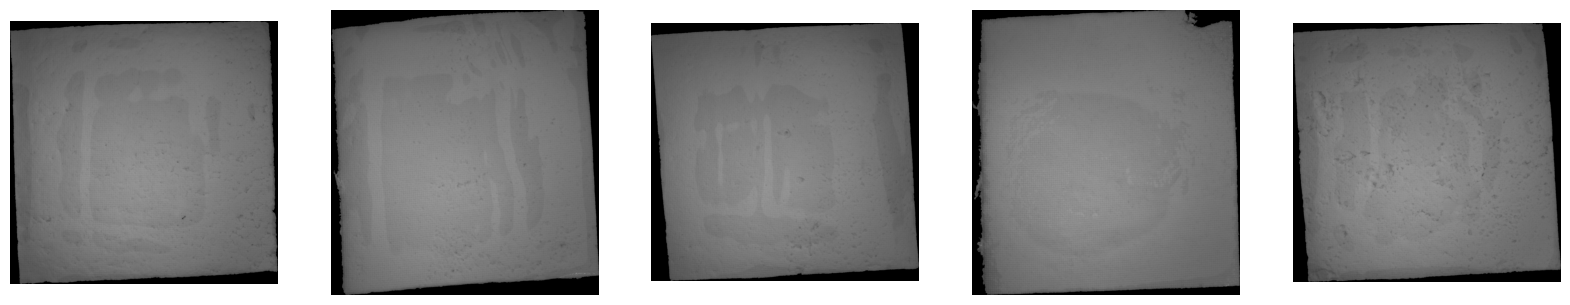

Cluster 1: 총 4개의 이미지


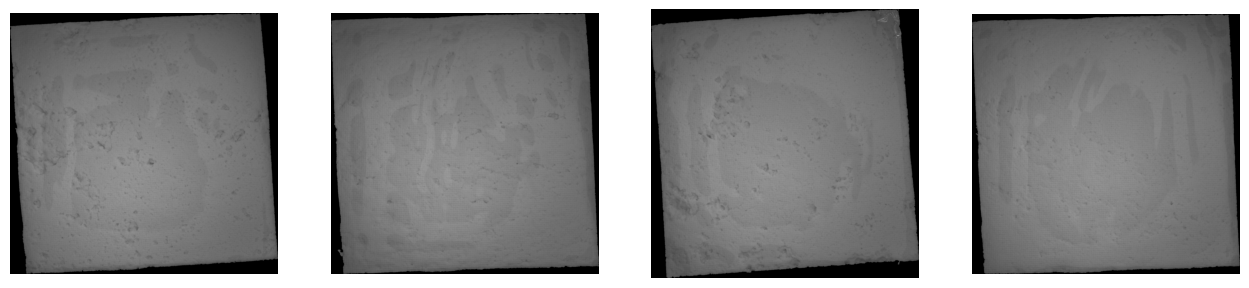

Cluster 2: 총 5개의 이미지


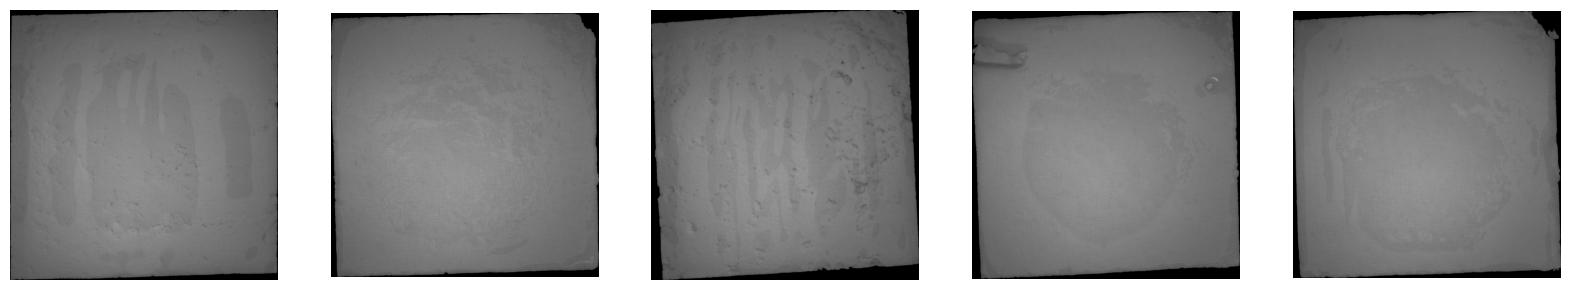

Cluster 3: 총 10개의 이미지


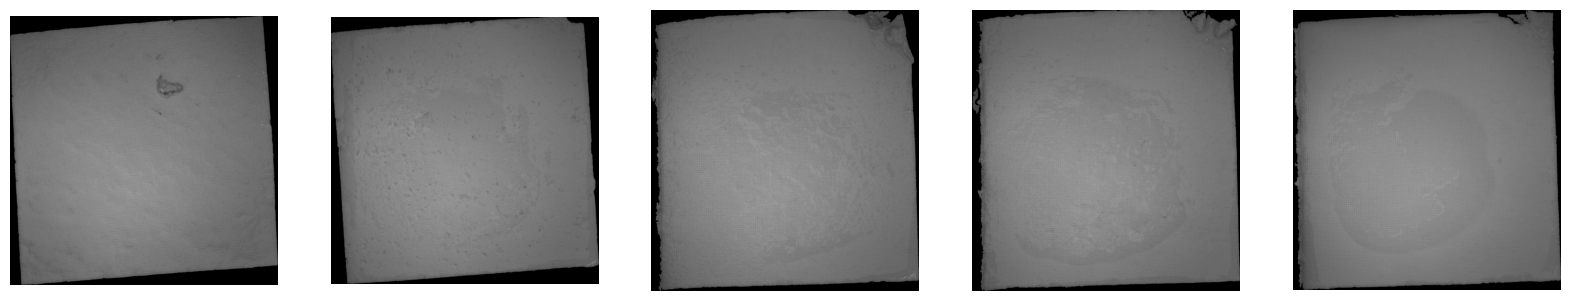

분류 결과가 ng_classification_results.csv에 저장되었습니다.

분류 결과:
File: 4572.bmp, Predicted Category: dent
File: 4343.bmp, Predicted Category: dent
File: 4328.bmp, Predicted Category: dent
File: 4899.bmp, Predicted Category: dent
File: 4367.bmp, Predicted Category: dent
File: 2586.bmp, Predicted Category: dent
File: 4491.bmp, Predicted Category: dent
File: 4376.bmp, Predicted Category: dent
File: 2202.bmp, Predicted Category: dent
File: 1195.bmp, Predicted Category: dent
File: 2659.bmp, Predicted Category: dent
File: 2027.bmp, Predicted Category: dent
File: 1804.bmp, Predicted Category: dent
File: 4386.bmp, Predicted Category: bubble
File: 4322.bmp, Predicted Category: dent
File: 4340.bmp, Predicted Category: dent
File: 1940.bmp, Predicted Category: dent
File: 4447.bmp, Predicted Category: foreignsub
File: 4345.bmp, Predicted Category: dent
File: 4356.bmp, Predicted Category: dent
File: 4612.bmp, Predicted Category: dent
File: 1243.bmp, Predicted Category: dent
File: 4379.bmp, Predicted Category:

In [29]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# 특성 추출 함수
def extract_kmeans_features(image, n_clusters=3):
    """이미지에서 K-means를 이용한 특성 추출"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 이미지를 1D 배열로 변환
    pixels = blurred.reshape(-1, 1)

    # K-means 클러스터링 적용
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)

    # 클러스터별 통계
    features = {}
    for i in range(n_clusters):
        cluster_pixels = pixels[labels == i]
        features[f'cluster_{i}_size'] = len(cluster_pixels) / len(pixels)
        features[f'cluster_{i}_mean'] = np.mean(cluster_pixels)
        features[f'cluster_{i}_std'] = np.std(cluster_pixels)

    return features

# NG 데이터 로드
def load_ng_data(folder_path):
    """NG 데이터를 로드"""
    images = []
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.bmp'):
            image_path = os.path.join(folder_path, file_name)
            img = cv2.imread(image_path)
            if img is not None:
                images.append({'image': img, 'filename': file_name})
            else:
                print(f"Warning: {file_name} 파일을 로드할 수 없습니다.")
    print(f"총 {len(images)}개의 NG 데이터를 로드했습니다.")
    return images

# 특성 추출
def extract_features_from_images(images):
    """NG 데이터에서 특성 추출"""
    feature_vectors = []
    for img_data in tqdm(images):
        features = extract_kmeans_features(img_data['image'])
        feature_vector = [v for v in features.values()]
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

# K-means 클러스터링
def cluster_images(features, n_clusters=4):
    """K-means 클러스터링을 이용한 이미지 분류"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans

# 결과 시각화
def visualize_clusters(images, labels, n_clusters=4):
    """클러스터링 결과를 시각화"""
    for cluster in range(n_clusters):
        cluster_images = [img['image'] for img, label in zip(images, labels) if label == cluster]
        print(f"Cluster {cluster}: 총 {len(cluster_images)}개의 이미지")
        plt.figure(figsize=(20, 5))
        for i, img in enumerate(cluster_images[:5]):  # 클러스터 내 상위 5개 이미지 표시
            plt.subplot(1, 5, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
        plt.show()

# 전체 워크플로
def main_kmeans(folder_path):
    # 1. 데이터 로드
    print("데이터 로드 중...")
    ng_data = load_ng_data(folder_path)

    # 2. 특성 추출
    print("특성 추출 중...")
    features = extract_features_from_images(ng_data)

    # 3. K-means 클러스터링
    print("K-means 클러스터링 진행 중...")
    labels, kmeans = cluster_images(features, n_clusters=4)

    # 4. 결과 시각화
    print("클러스터링 결과 시각화")
    visualize_clusters(ng_data, labels)

    # 5. 클러스터 이름 매핑 (수동으로 확인 후)
    cluster_names = {0: 'dent', 1: 'torn', 2: 'bubble', 3: 'foreignsub'}
    results = [{'filename': img['filename'], 'predicted_category': cluster_names[label]} for img, label in zip(ng_data, labels)]

    
    save_results_to_csv(results, output_path)
    # 결과 출력
    print("\n분류 결과:")
    for result in results:
        print(f"File: {result['filename']}, Predicted Category: {result['predicted_category']}")

if __name__ == "__main__":
    folder_path = '/home/ec2-user/SageMaker/data/NG'  # NG 데이터 경로
    output_path = 'ng_classification_results.csv'  # 결과 저장 경로
    main_kmeans(folder_path)
